# Playground Series - Season 4, Episode 1 - Binary Classification with a Bank Churn Dataset

In [226]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import optuna
from datetime import datetime as dt

# STATISTICS
from statsmodels.graphics.gofplots import qqplot

#notebook settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

#category encoders
from category_encoders import BinaryEncoder


#sklearn libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, Binarizer, LabelEncoder, OneHotEncoder, TargetEncoder, LabelEncoder, OrdinalEncoder
# metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,auc, accuracy_score
# imbalanced datasets
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import TomekLinks,RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel
# model selection
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold
# pipelines
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.utils import class_weight

#calibration
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve

## READING FILES

**Bank Customer Churn Dataset**

The Bank Customer Churn Dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be customers. The dataset includes the following attributes:
- Customer ID: A unique identifier for each customer.
- Surname: The customer's surname or last name.
- Credit Score: A numerical value representing the customer's credit score.
- Geography: The country where the customer resides (France, Spain, or Germany).
- Gender: The customer's gender (Male or Female).
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank.
- Balance: The customer's account balance.
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card).
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no).
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no).
- EstimatedSalary: The estimated salary of the customer.
- Exited: Whether the customer has churned (1 = yes, 0 = no).

In [227]:
train_df = pd.read_csv('data/train.csv', index_col='id')
test_df = pd.read_csv('data/test.csv',index_col='id')
submission = pd.read_csv('data/sample_submission.csv')

## 1) EDA - Exploratory Data Analysis

### 1.1) Checking for missing values

In [228]:
train_df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [229]:
train_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [230]:
test_df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [231]:
test_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


No missing Values in train and test data 😃✅

### 1.2) Checking for duplicated values

In [232]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

0
0


No duplicated Values in train and test data 😃✅

### 1.3) Size of train and test data

In [233]:
print(train_df.shape)
print(test_df.shape)

(165034, 13)
(110023, 12)


### 1.4) Uniques values

In [234]:
# let's start looking at the training data
train_df.nunique()

CustomerId         23221
Surname             2797
CreditScore          457
Geography              3
Gender                 2
Age                   71
Tenure                11
Balance            30075
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
Exited                 2
dtype: int64

### 1.5) data type information

In [235]:
train_df.dtypes

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64


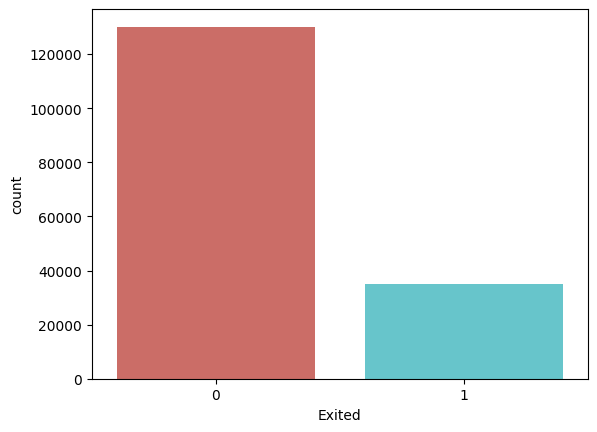

In [236]:
# let's look at the target variable
print(train_df['Exited'].value_counts(normalize=True))


# let's look at the distribution of the target variable
sns.countplot(x='Exited', data=train_df, palette='hls'); #imbalanced dataset

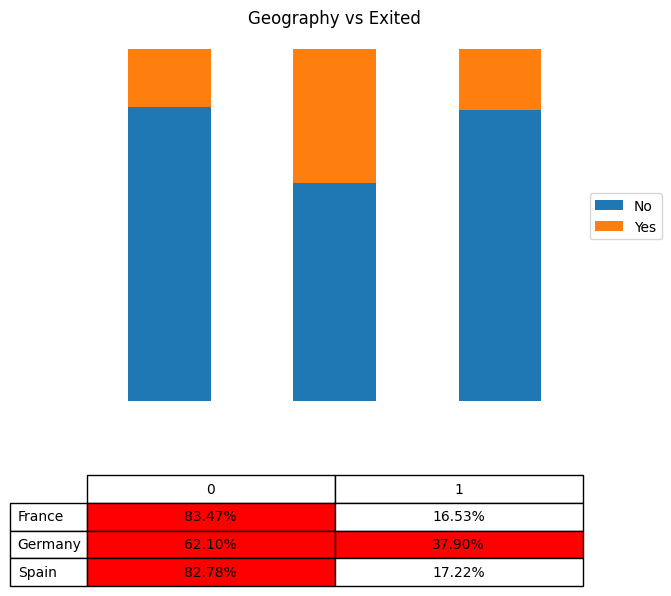

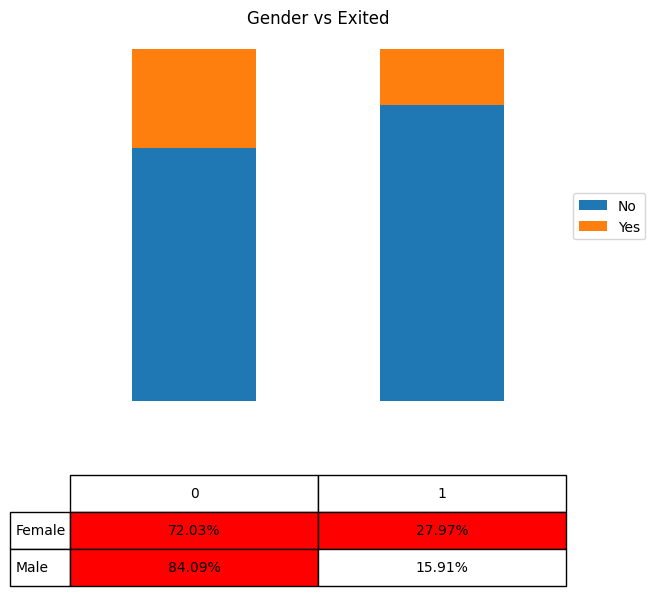

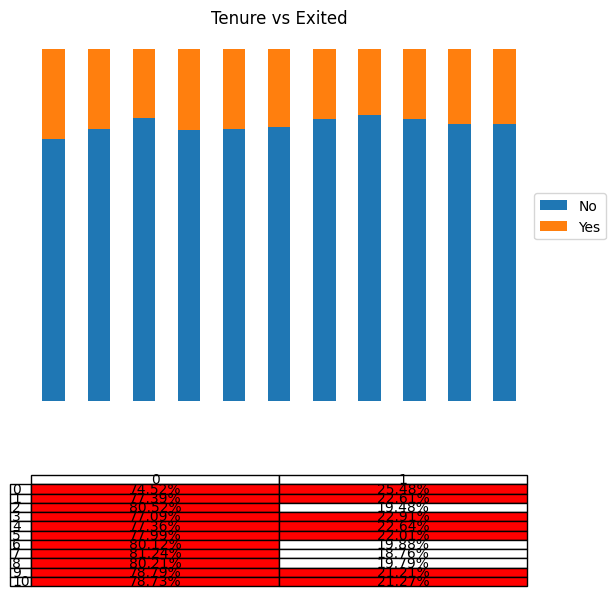

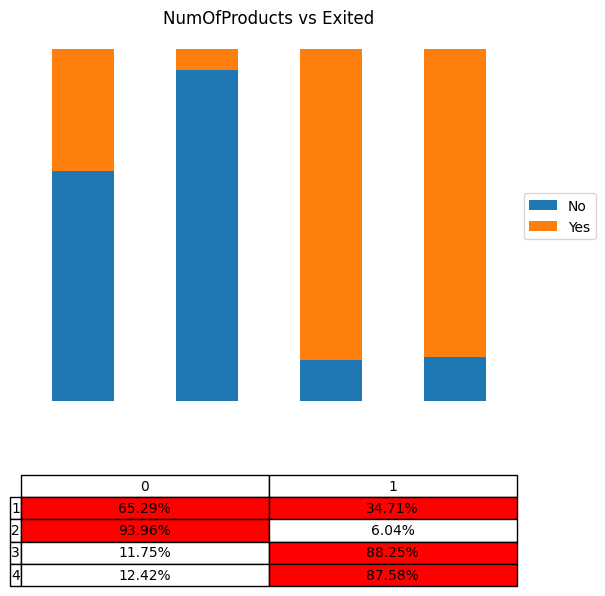

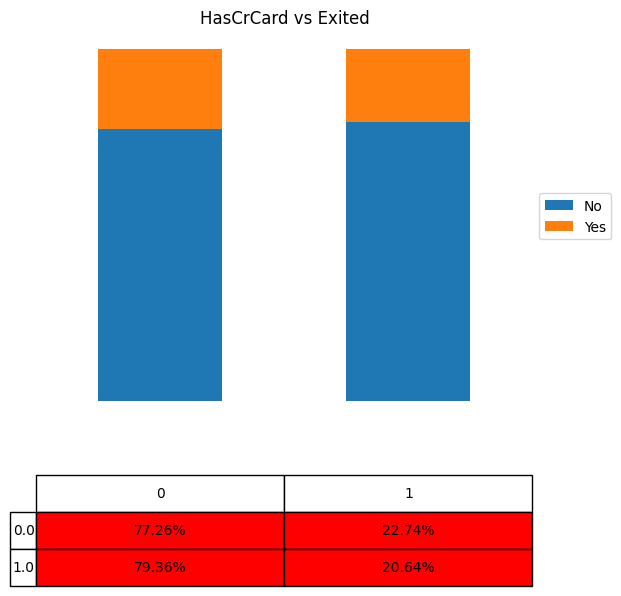

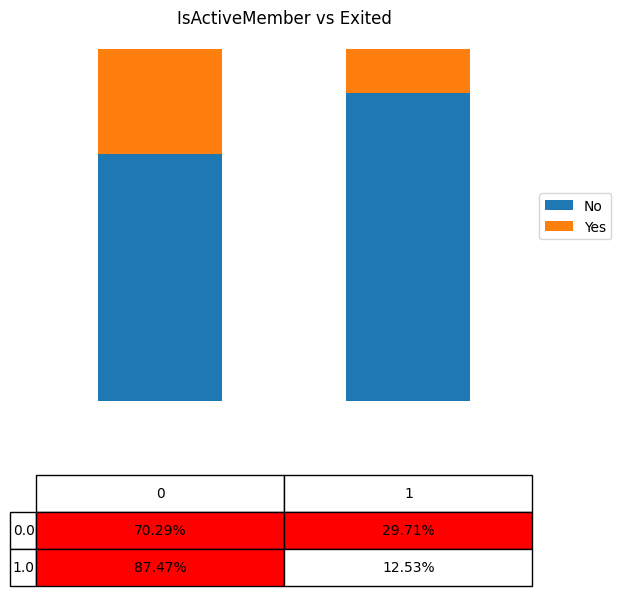

In [237]:
# checking proportions or target variable for categorical and numerical variables with unique values less than 15

def check_proportions(df, col, threshold=0.2):
    proportions = df.groupby(col)['Exited'].value_counts(normalize=True).unstack()
    proportions.plot(kind='bar', stacked=True)
    
    # Move the legend to the side of the bars
    plt.legend(['No','Yes'],loc='center left', bbox_to_anchor=(1, 0.5))
    
    # add title
    plt.title(f'{col} vs Exited')
    
    # Create a table below the graph
    table_data = []
    cell_colors = []
    for i in range(len(proportions)):
        row_data = []
        row_colors = []
        for j in range(len(proportions.columns)):
            value = proportions.iloc[i, j]
            if value > threshold:
                row_data.append(f'{value:.2%}')
                row_colors.append('red')  # Highlight imbalanced values with red color
            else:
                row_data.append(f'{value:.2%}')
                row_colors.append('white')
        table_data.append(row_data)
        cell_colors.append(row_colors)
    
    table = plt.table(cellText=table_data,
                      colLabels=proportions.columns,
                      rowLabels=proportions.index,
                      loc='bottom',
                      cellLoc='center',
                      bbox=[0, -0.5, 1, 0.3],  # Increase the height by modifying the bbox parameter
                      cellColours=cell_colors)  # Set cell colors
    
    # Hide the axes and axis labels
    plt.axis('off')
    
    plt.show()

# selecting columns with unique values less than 15
cols = train_df.columns[train_df.nunique() < 15].tolist()
cols.remove('Exited')

# apply to all variables and plot the proportions
for col in cols:    
    check_proportions(train_df, col)


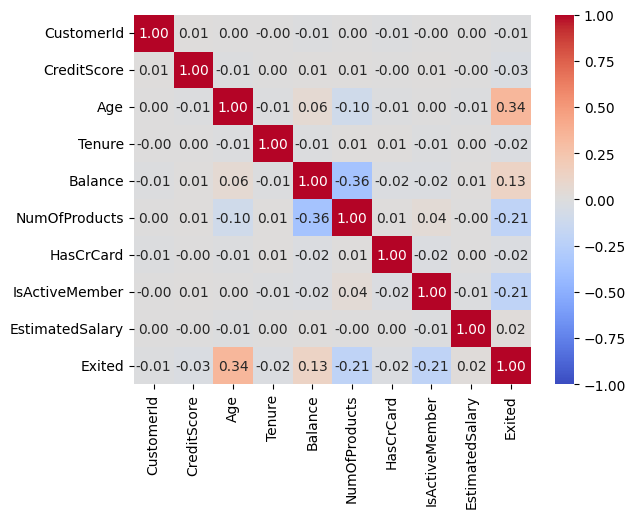

In [238]:
correlation_matrix = train_df.select_dtypes(exclude='object').corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix.round(2), 
            xticklabels=column_names, 
            yticklabels=column_names,
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            annot=True,
            fmt=".2f");


Possible issues due to correlations:

- Exited possible issues: 
  - Age
  - Balance
  - NumOfProducts
  - IsActiveMember

- between features:
  - Balance vs NumOfProducts
  - Age vs NumOfProducts

Feature Binning:

For continuous variables like "Age" or "Balance," consider binning or discretizing them into categories. 
This can help capture non-linear relationships and reduce sensitivity to outliers.

## 2) PreProcess Data

In [267]:
# class transformer that will help us to create the new features Surname_Length, Surname_Frequency and Surname_Ratio_Frequency_Length
class CreateSurnameFeatures(BaseEstimator, TransformerMixin):
    """This class helps to create new features based on the 'Surname' column."""
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['Surname_Length'] = data['Surname'].apply(len)
        data['Surname_Frequency'] = data['Surname'].map(data['Surname'].value_counts())
        data['Surname_Ratio_Frequency_Length'] = data['Surname_Frequency'] / data['Surname_Length']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['Surname_Length', 'Surname_Frequency', 'Surname_Ratio_Frequency_Length']

# this class will create a new feature based on balance to salary ratio
class BalanceSalaryRatio(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['BalanceSalaryRatio'] = data['Balance'] / data['EstimatedSalary']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['BalanceSalaryRatio']

# this class will create a new feature of num of products and has card interaction
class NumOfProductsHasCrCardInteraction(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['NumOfProductsHasCrCardInteraction'] = data['NumOfProducts'] * data['HasCrCard']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['NumOfProductsHasCrCardInteraction']

# this class will create a new feature based on the relation between balance and number of products
class BalanceNumOfProductsInteraction(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['BalanceNumOfProductsInteraction'] = data['Balance'] * data['NumOfProducts']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['BalanceNumOfProductsInteraction']

# this class will create a new feature based on age and number of products
class AgeNumOfProductsInteraction(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['AgeNumOfProductsInteraction'] = data['Age'] * data['NumOfProducts']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['AgeNumOfProductsInteraction']

# this class will create a new feature based on tenure and age ratio
class TenureAgeRatio(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['TenureAgeRatio'] = data['Tenure'] / data['Age']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['TenureAgeRatio']

# this class will create a new feature based on Geography, IsActiveMember, Gender
class GeographyIsActiveMemberGenderInteraction(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Assuming 'Geography', 'IsActiveMember', and 'Gender' are existing columns in your DataFrame
        # You can modify this logic based on your specific requirements
        X['GeographyIsActiveMemberGenderInteraction'] = (
            X['Geography'] + '_' + 
            X['IsActiveMember'].astype(str) + '_' + 
            X['Gender']
        )
        
        return X
        
# this class will create a new  feature based on based on tenure and is active member and class it LoyaltyScore
class LoyaltyScore(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['LoyaltyScore'] = data['Tenure'] * data['IsActiveMember']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['LoyaltyScore']

# this class will help us to drop unwanted columns
class DropUnwantedColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        return data.drop(labels=self.columns, axis='columns')

    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col not in self.columns]

# this class will help us bin the age variable
class AgeBinner(BaseEstimator, TransformerMixin):
    def __init__(self, num_bins):
        self.num_bins = num_bins

    def fit(self, X, y=None):
        # Calculate bin edges dynamically based on data distribution
        _, bin_edges = pd.cut(X['Age'], bins=self.num_bins, retbins=True)
        self.bin_edges = bin_edges
        return self

    def transform(self, X):
        data = X.copy()
        bin_labels = [f'{int(self.bin_edges[i])}-{int(self.bin_edges[i+1])}' for i in range(len(self.bin_edges)-1)]
        data['Age_Bins'] = pd.cut(data['Age'], bins=self.bin_edges, labels=bin_labels, precision=0)
        data['Age_Bins'] = data['Age_Bins'].astype('object')
        return data

    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col not in self.columns]

# this class will help us bin credit score
class CreditScoreBinner(BaseEstimator, TransformerMixin):
    def __init__(self, num_bins):
        self.num_bins = num_bins

    def fit(self, X, y=None):
        # Calculate bin edges dynamically based on data distribution
        _, bin_edges = pd.cut(X['CreditScore'], bins=self.num_bins, retbins=True)
        self.bin_edges = bin_edges
        return self

    def transform(self, X):
        data = X.copy()
        bin_labels = [f'{int(self.bin_edges[i])}-{int(self.bin_edges[i+1])}' for i in range(len(self.bin_edges)-1)]
        data['CreditScore_Bins'] = pd.cut(data['CreditScore'], bins=self.bin_edges, labels=bin_labels, precision=0)
        data['CreditScore_Bins'] = data['CreditScore_Bins'].astype('object')
        return data

    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col not in self.columns]

# class helps select columns categorical or numerical columns
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, dtypes=None):
        self.columns = columns
        self.dtypes = dtypes

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        if self.columns:
            data = data[self.columns]
        if self.dtypes:
            data = data.select_dtypes(include=self.dtypes)
        return data

    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col in self.columns]



# selections of columns ------------------------------------------------------------
# columns for DropColumns transformer
columns_to_drop = ['CustomerId', 'Surname', 'Age', 'CreditScore']

# identifying categorical and numerical features
cat_ohe_features = ['Age_Bins','CreditScore_Bins','Tenure','NumOfProducts','Geography','Gender'] # order does not matter

num_features = ['EstimatedSalary', 'Surname_Length', 'Surname_Frequency', 'Surname_Ratio_Frequency_Length' \
    ,'BalanceSalaryRatio', 'NumOfProductsHasCrCardInteraction','TenureAgeRatio','LoyaltyScore','BalanceNumOfProductsInteraction'\
    ,'AgeNumOfProductsInteraction','Balance']


# building a pipeline for categorical features --------------------------------------
cat_ohe_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# building a pipeline for numerical features ----------------------------------------
num_pipeline = Pipeline(steps=[
    ('robust_scaler', RobustScaler())
])

# let's join the numerical and categorical pipelines --------------------------------
preprocessor = ColumnTransformer(transformers=[
    ('cat_ohe', cat_ohe_pipeline, cat_ohe_features),
    ('num', num_pipeline, num_features),
    ('pass', 'passthrough', ['HasCrCard','IsActiveMember'])
])

pipeline = Pipeline(steps=[
    ('fix_surname', CreateSurnameFeatures()),
    ('feat_balance_salary_ratio', BalanceSalaryRatio()),
    ('feat_num_of_products_has_cr_card_interaction', NumOfProductsHasCrCardInteraction()),
    ('feat_tenure_age_ratio', TenureAgeRatio()),
    ('feat_balance_num_of_products_interaction', BalanceNumOfProductsInteraction()),
    ('feat_age_num_of_products_interaction', AgeNumOfProductsInteraction()),
    ('feat_loyalty_score', LoyaltyScore()),
    #('feat_geography_isactive_gender_interaction', GeographyIsActiveMemberGenderInteraction()),
    ('bin_age', AgeBinner(num_bins=4)),
    ('bin_credit_score', CreditScoreBinner(num_bins=5)),
    ('drop_unwanted_columns', DropUnwantedColumns(columns=columns_to_drop)),
    ('preprocessor', preprocessor),
])

pipeline


Pipeline(steps=[('fix_surname', CreateSurnameFeatures()),
                ('feat_balance_salary_ratio', BalanceSalaryRatio()),
                ('feat_num_of_products_has_cr_card_interaction',
                 NumOfProductsHasCrCardInteraction()),
                ('feat_tenure_age_ratio', TenureAgeRatio()),
                ('feat_balance_num_of_products_interaction',
                 BalanceNumOfProductsInteraction()),
                ('feat_age_num_of_products_interacti...
                                                  Pipeline(steps=[('robust_scaler',
                                                                   RobustScaler())]),
                                                  ['EstimatedSalary',
                                                   'Surname_Length',
                                                   'Surname_Frequency',
                                                   'Surname_Ratio_Frequency_Length',
                                                   'BalanceSalaryRatio',
                                                   'NumOfProductsHasCrCardInteraction',
                                                   'TenureAgeRatio',
                                                   'LoyaltyScore',
                                                   'BalanceNumOfProductsInteraction',
                                                   'AgeNumOfProductsInteraction',
                                                   'Balance']),
                                                 ('pass', 'passthrough',
                                                  ['HasCrCard',
                                                   'IsActiveMember'])]))])

In [268]:
# let's test the pipeline on the training data
X_train = pipeline.fit_transform(train_df)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# create a dataframe with the transformed data and feature names
X_transformed = pd.DataFrame(X_train, columns=feature_names)

print('X_transformed shape: {}'.format(X_transformed.shape))
print('y shape: {}'.format(train_df['Exited'].shape))

# check dataframe head
X_transformed.head()

X_transformed shape: (165034, 42)
y shape: (165034,)


,cat_ohe__Age_Bins_17-36,cat_ohe__Age_Bins_36-55,cat_ohe__Age_Bins_55-73,cat_ohe__Age_Bins_73-92,cat_ohe__CreditScore_Bins_349-450,cat_ohe__CreditScore_Bins_450-550,cat_ohe__CreditScore_Bins_550-650,cat_ohe__CreditScore_Bins_650-750,cat_ohe__CreditScore_Bins_750-850,cat_ohe__Tenure_0,cat_ohe__Tenure_1,cat_ohe__Tenure_2,cat_ohe__Tenure_3,cat_ohe__Tenure_4,cat_ohe__Tenure_5,cat_ohe__Tenure_6,cat_ohe__Tenure_7,cat_ohe__Tenure_8,cat_ohe__Tenure_9,cat_ohe__Tenure_10,cat_ohe__NumOfProducts_1,cat_ohe__NumOfProducts_2,cat_ohe__NumOfProducts_3,cat_ohe__NumOfProducts_4,cat_ohe__Geography_France,cat_ohe__Geography_Germany,cat_ohe__Geography_Spain,cat_ohe__Gender_Female,cat_ohe__Gender_Male,num__EstimatedSalary,num__Surname_Length,num__Surname_Frequency,num__Surname_Ratio_Frequency_Length,num__BalanceSalaryRatio,num__NumOfProductsHasCrCardInteraction,num__TenureAgeRatio,num__LoyaltyScore,num__BalanceNumOfProductsInteraction,num__AgeNumOfProductsInteraction,num__Balance,pass__HasCrCard,pass__IsActiveMember
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.788698,2.666667,-0.156347,-0.237057,0.00000,1.0,-0.308530,0.0,0.000000,0.285714,0.000000,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.850085,2.333333,-0.095975,-0.206351,0.00000,1.0,-0.768300,0.2,0.000000,0.285714,0.000000,1.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.831134,-0.333333,1.461300,1.442646,0.00000,1.0,0.898367,0.0,0.000000,0.685714,0.000000,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.414670,-1.000000,1.880805,3.274073,1.79876,0.0,-0.551938,0.4,1.137823,-0.628571,1.241313,1.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.277766,1.000000,-0.179567,-0.176876,0.00000,1.0,0.151240,1.0,0.000000,0.285714,0.000000,1.0,1.0


In [269]:
# use xgboost as the model for our pipeline
params = {
    'objective': 'binary:logistic',
    'n_jobs': -1,
    'eval_metric': 'roc_auc'
}
    
model = xgb.XGBClassifier(params=params)


# let's create a pipeline with our previous pipeline (preprocessor) and the model
xgb_pipe = Pipeline(steps=[
    ('preprocessor', pipeline),
    ('xgboost', model)
])

# let's train our model
xgb_pipe.fit(train_df, train_df['Exited'])

# let's make predictions on the test set
predictions = xgb_pipe.predict_proba(test_df)[:, 1]

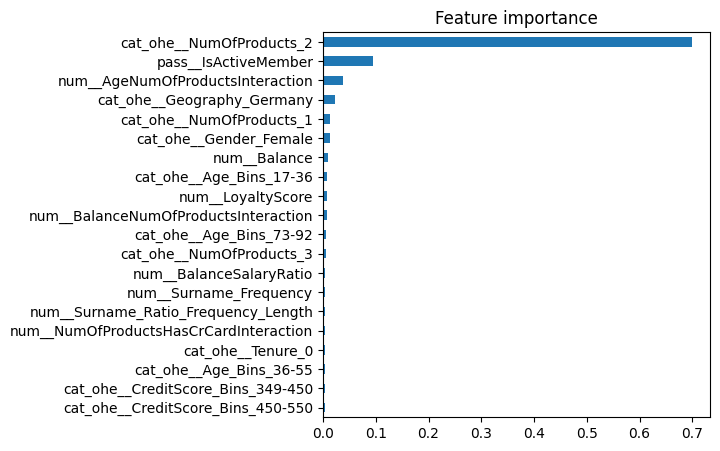

In [270]:
# let's create a function to plot the feature importance
def plot_feature_importance(model, X, y):
    plt.figure(figsize=(5, 5))
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(20).sort_values(ascending=True).plot(kind='barh')
    plt.title('Feature importance')
    plt.show()

plot_feature_importance(xgb_pipe.named_steps['xgboost'], X_transformed, train_df['Exited'])

In [264]:
# create a dataframe of feature importance values sorted by importance
feature_importance = pd.DataFrame({'feature': X_transformed.columns, 'importance': xgb_pipe.named_steps['xgboost'].feature_importances_}).sort_values(by='importance', ascending=False)
feature_importance

,feature,importance
0,cat_ohe__Age_Bins_17-36,0.607185
25,num__NumOfProductsHasCrCardInteraction,0.113150
29,num__AgeNumOfProductsInteraction,0.065461
27,num__LoyaltyScore,0.054334
9,cat_ohe__Tenure_0,0.016116
1,cat_ohe__Age_Bins_36-55,0.011527
28,num__BalanceNumOfProductsInteraction,0.010776
3,cat_ohe__Age_Bins_73-92,0.009695
30,num__Balance,0.009008
2,cat_ohe__Age_Bins_55-73,0.007488


In [271]:
X = train_df
y = train_df['Exited']

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  stratify=y,
                                                  random_state=42)


def objective(trial):
    params = {
        "objective": "binary:logistic",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 100.0),
    }

    model = xgb.XGBClassifier(**params)
    
    #use pipeline
    xgb_pipe = Pipeline(steps=[
        ('preprocessor', pipeline),
        ('xgboost', model)
    ])
    
    #fit model
    xgb_pipe.fit(X_train, y_train)
    
    #roc auc score
    predictions = xgb_pipe.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, predictions)
    
    return roc_auc

In [272]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-01-14 21:47:56,775] A new study created in memory with name: no-name-f429cf24-d8d2-445b-9073-025e495f8445
[I 2024-01-14 21:47:59,983] Trial 0 finished with value: 0.8883793442658598 and parameters: {'n_estimators': 377, 'learning_rate': 0.0724079163594275, 'max_depth': 3, 'subsample': 0.710477530296896, 'colsample_bytree': 0.37193414823545545, 'min_child_weight': 18, 'gamma': 0.16072252946791477, 'scale_pos_weight': 35.51705096823046}. Best is trial 0 with value: 0.8883793442658598.
[I 2024-01-14 21:48:07,503] Trial 1 finished with value: 0.887062350760379 and parameters: {'n_estimators': 907, 'learning_rate': 0.024592875107303847, 'max_depth': 5, 'subsample': 0.8808992881443926, 'colsample_bytree': 0.7720573402764885, 'min_child_weight': 5, 'gamma': 0.8336107668284706, 'scale_pos_weight': 53.00265887104283}. Best is trial 0 with value: 0.8883793442658598.
[I 2024-01-14 21:48:11,240] Trial 2 finished with value: 0.8883985580382918 and parameters: {'n_estimators': 450, 'learning

Number of finished trials:  50
Best trial:
  Value: 0.8889086226216573
  Params: 
    n_estimators: 831
    learning_rate: 0.010809187890268284
    max_depth: 5
    subsample: 0.9262238385296637
    colsample_bytree: 0.7022466668237255
    min_child_weight: 20
    gamma: 0.647566412944823
    scale_pos_weight: 75.99215572549936


In [273]:
params = trial.params

model_opt = xgb.XGBClassifier(**params)
    
# let's create a pipeline with our previous pipeline (preprocessor) and the model
xgb_opt = Pipeline(steps=[
    ('preprocessor', pipeline),
    ('xgboost', model_opt)
])

# let's train our model
xgb_opt.fit(train_df, train_df['Exited'])

# let's make predictions on the test set
predictions_optimized = xgb_opt.predict_proba(test_df)[:, 1]

In [274]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(estimator=xgb_pipe, 
                         X=train_df, 
                         y=train_df['Exited'], 
                         cv=cv,
                         scoring='roc_auc',
                         n_jobs=-1,
                         verbose=1)


scores_opt = cross_val_score(estimator=xgb_opt, 
                         X=train_df, 
                         y=train_df['Exited'], 
                         cv=cv,
                         scoring='roc_auc',
                         n_jobs=-1,
                         verbose=1)

# print scores and scores_opt
print('ROC AUC scores for the 10 folds: ', scores)
print('Mean ROC AUC score: %.3f' % scores.mean())

print('ROC AUC scores for the 10 folds: ', scores_opt)
print('Mean ROC AUC score: %.3f' % scores_opt.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


ROC AUC scores for the 10 folds:  [0.88226582 0.87839673 0.8827927  0.88041457 0.87754578 0.88797071
 0.88079168 0.88191226 0.8806104  0.87788645]
Mean ROC AUC score: 0.881
ROC AUC scores for the 10 folds:  [0.89072088 0.8856636  0.88909615 0.88747185 0.88539818 0.89347315
 0.88768989 0.89100076 0.88759983 0.88517654]
Mean ROC AUC score: 0.888


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   43.4s finished


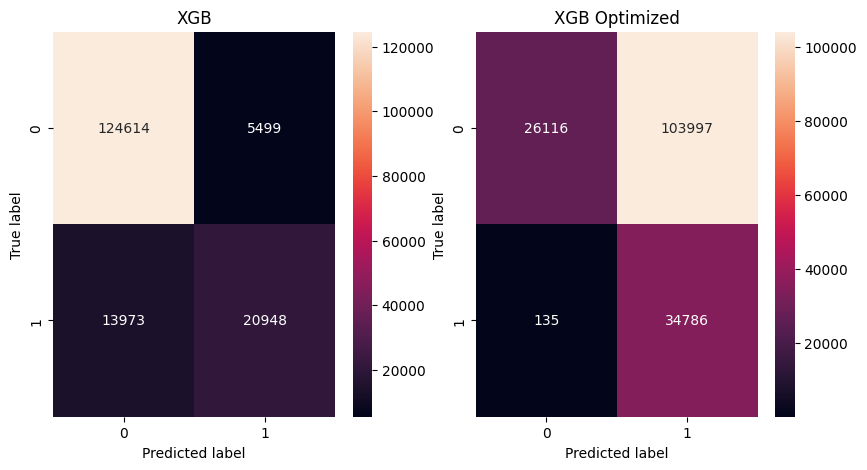

In [275]:
# plot confusion matrix for xgb and xgb_opt side by side with sns and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(confusion_matrix(train_df['Exited'], xgb_pipe.predict(train_df)), annot=True, fmt='d', ax=ax1)
sns.heatmap(confusion_matrix(train_df['Exited'], xgb_opt.predict(train_df)), annot=True, fmt='d', ax=ax2)
ax1.set_title('XGB')
ax2.set_title('XGB Optimized')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
plt.show()

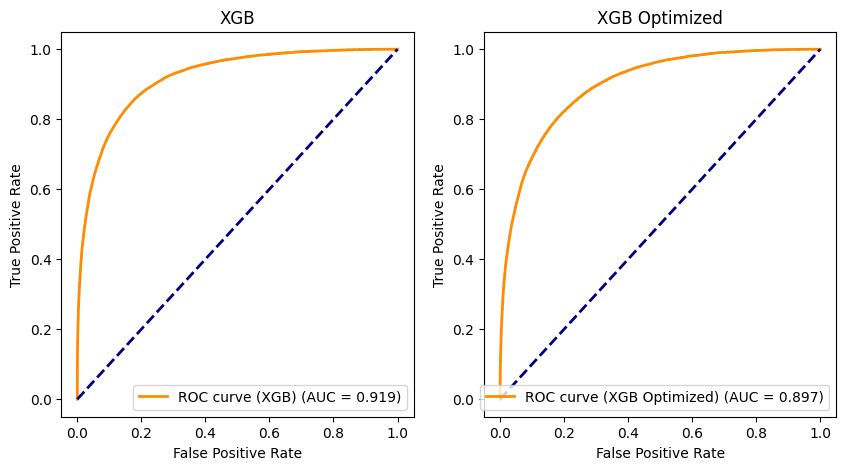

In [276]:
# plot roc curve for xgb and xgb_opt side by side with sns and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fpr_xgb, tpr_xgb, _ = roc_curve(train_df['Exited'], xgb_pipe.predict_proba(train_df)[:, 1])
fpr_xgb_opt, tpr_xgb_opt, _ = roc_curve(train_df['Exited'], xgb_opt.predict_proba(train_df)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_xgb_opt = auc(fpr_xgb_opt, tpr_xgb_opt)
ax1.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (XGB) (AUC = %0.3f)' % roc_auc_xgb)
ax2.plot(fpr_xgb_opt, tpr_xgb_opt, color='darkorange', lw=2, label='ROC curve (XGB Optimized) (AUC = %0.3f)' % roc_auc_xgb_opt)
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_title('XGB')
ax2.set_title('XGB Optimized')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right")
ax2.legend(loc="lower right")
plt.show()


[learning_curve] Training set sizes: [  1485  17823  34161  50500  66838  83176  99515 115853 132191 148530]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.6s finished


[learning_curve] Training set sizes: [  1485  17823  34161  50500  66838  83176  99515 115853 132191 148530]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished


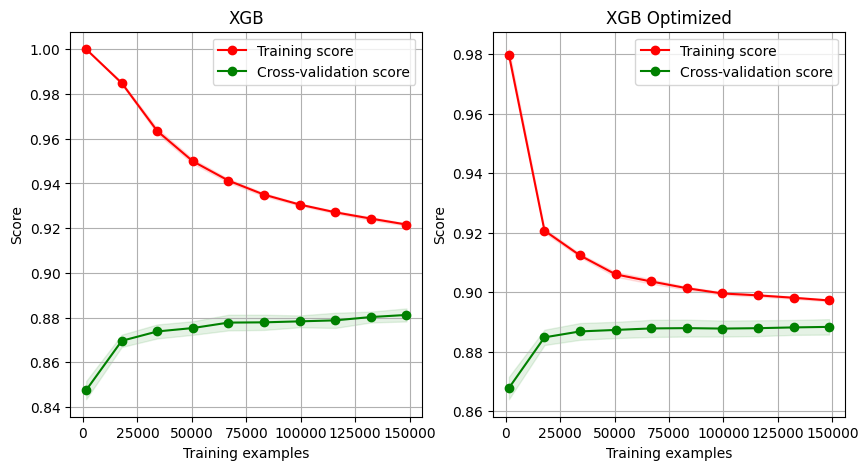

In [277]:
# plot learning curve for xgb and xgb_opt side by side with sns and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
train_sizes, train_scores, test_scores = learning_curve(xgb_pipe, train_df, train_df['Exited'], cv=cv, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 10), verbose=1)
train_sizes_opt, train_scores_opt, test_scores_opt = learning_curve(xgb_opt, train_df, train_df['Exited'], cv=cv, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 10), verbose=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_mean_opt = np.mean(train_scores_opt, axis=1)
train_scores_std = np.std(train_scores, axis=1)
train_scores_std_opt = np.std(train_scores_opt, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_mean_opt = np.mean(test_scores_opt, axis=1)
test_scores_std = np.std(test_scores, axis=1)
test_scores_std_opt = np.std(test_scores_opt, axis=1)
ax1.grid()
ax2.grid()
ax1.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
ax1.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
ax2.fill_between(train_sizes_opt, train_scores_mean_opt - train_scores_std_opt, train_scores_mean_opt + train_scores_std_opt, alpha=0.1, color='r')
ax2.fill_between(train_sizes_opt, test_scores_mean_opt - test_scores_std_opt, test_scores_mean_opt + test_scores_std_opt, alpha=0.1, color='g')
ax1.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
ax1.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
ax2.plot(train_sizes_opt, train_scores_mean_opt, 'o-', color='r', label='Training score')
ax2.plot(train_sizes_opt, test_scores_mean_opt, 'o-', color='g', label='Cross-validation score')
ax1.set_title('XGB')
ax2.set_title('XGB Optimized')
ax1.set_xlabel('Training examples')
ax1.set_ylabel('Score')
ax2.set_xlabel('Training examples')
ax2.set_ylabel('Score')
ax1.legend(loc='best')
ax2.legend(loc='best')
plt.show()

## 3) Submission

In [122]:
# add to submission dataframe
submission['Exited'] = predictions_optimized

# save to csv
submission.to_csv('data/submission_18.csv', index=False)

# Best value for my model was: 0.88634 - submission 11